# Jupyter Notebook for solving the Traveling Salesman Problem on D-Wave


This notebook has the aim to give an example of how to solve problems in the D-Wave computer using python and the Amazon AWS Braket platform. 

For this case we will use the traveling salesman problem.


This notebook is based on a example of the Amazon AWS platform. 

In [61]:
import boto3
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler

import numpy as np
import networkx as nx
import dimod
import dwave_networkx as dnx
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite
import matplotlib.pyplot as plt


%matplotlib inline
from collections import defaultdict
import itertools

# local imports
from utils_tsp import get_distance, traveling_salesperson

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
# Amazon AWS informations 

bucket = f"amazon-braket-Your-Bucket-Name" # bucket name 
folder = "Folder" # folder name 
s3_infos = (bucket, folder)

###### Information about our points 

To guarantee reproducibility, we are supplying the points that we use in this example, which are 6 random points distributed in space.

We say reproducibility, because the arrangement of the points can interfere in the difficult of the problem, since it can increase the deep of the local minimums.

(-0.75, 37.75, 9.8, 36.2)

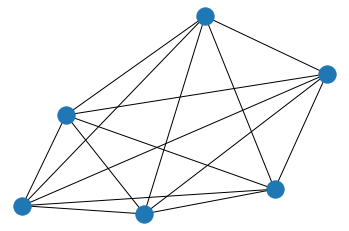

In [75]:

pos = np.array([[22, 35],
       [15,  11],
       [ 6, 23],
       [ 1, 12],
       [36, 28],
       [30, 14]])




adj = np.zeros((6,6))
for i in range(6):
    for j in range(6):
        adj[i][j] = np.sqrt((pos[i][0]-pos[j][0])**2 + (pos[i][1]-pos[j][1])**2)
        
# Creating the Graph         
G = nx.from_numpy_matrix(adj)
# get characteristics of graph
nodes = G.nodes()
edges = G.edges()
weights = nx.get_edge_attributes(G,'weight');


nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
plt.axis('off')


### Best Solution 

For the traveling salesman problem having six cities, it is possible to find the best solution by using the brute force algorithm on a classical computer. 

For this data, 
the best route is: $0\rightarrow 2 \rightarrow  3 \rightarrow  1 \rightarrow  5 \rightarrow  4$. 

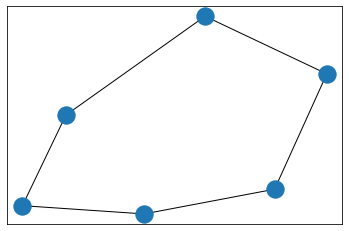

In [76]:
Exact_route = [0, 2, 3, 1, 5, 4]
Exact_weights = [(Exact_route[i], (Exact_route[(i+1)%6])) for i in range(6)]
G_best = nx.from_edgelist(Exact_weights)

nx.draw_networkx_nodes(G_best, pos)
nx.draw_networkx_edges(G_best, pos)

### Going Quantum

Now, let us try to solve it on the D-Wave quantum annealer: 

In [77]:
# get QUBO for TSP
tsp_qubo = dnx.algorithms.tsp.traveling_salesperson_qubo(G)

In [78]:
#Here we will look for the Best Lagrange parameters. The Ocean documentation says that good values can found between 75-150%.


lagrange = None
weight='weight'

# get corresponding QUBO step by step
N = G.number_of_nodes()

if lagrange is None:
    # If no lagrange parameter provided, set to 'average' tour length.
    # Usually a good estimate for a lagrange parameter is between 75-150%
    # of the objective function value, so we come up with an estimate for 
    # tour length and use that.
    if G.number_of_edges()>0:
        lagrange = G.size(weight=weight)*G.number_of_nodes()/G.number_of_edges()
    else:
        lagrange = 2

print('Default Lagrange parameter:', lagrange)   

Default Lagrange parameter: 134.61352242087915


In [80]:
# create list of possible good lagrange parameters 
lagrange_pars = list(np.arange(int(0.9*lagrange), int(1.2*lagrange), 5))
print('Lagrange parameter for HPO:', lagrange_pars)

Lagrange parameter for HPO: [121, 126, 131, 136, 141, 146, 151, 156]


In [81]:
# run TSP with imported TSP routine
# For using the D-Wave 2000Q use 
#sampler = BraketDWaveSampler(s3_folder,'arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')

sampler = BraketDWaveSampler(s3_folder,'arn:aws:braket:::device/qpu/d-wave/Advantage_system1')
sampler = EmbeddingComposite(sampler)

# set parameters
num_shots = 500
start_city = 0
best_distance = sum(weights.values())
best_route = [None]*len(G)

# run HPO to find route
for lagrange in lagrange_list:
    print('Running quantum annealing for TSP with Lagrange parameter=', lagrange)
    route = traveling_salesperson(G, sampler, lagrange=lagrange, 
                                  start=start_city, num_reads=num_shots, answer_mode="histogram")
    # print route 
    print('Route found with D-Wave:', route)
    
    # print distance
    total_dist, distance_with_return = get_distance(route, adj)
    
    # update best values
    if distance_with_return < best_distance:
        best_distance = distance_with_return
        best_route = route

print('---FINAL SOLUTION---')
print('Best solution found with D-Wave:', best_route)
print('Total distance (including return):', best_distance)

Running quantum annealing for TSP with Lagrange parameter= 121
Route found with D-Wave: [0, 5, 2, 3, 4, 1]
Total distance (without return): 125.6895372457917
Total distance (including return): 150.6895372457917
Running quantum annealing for TSP with Lagrange parameter= 126
Route found with D-Wave: [0, 3, 4, 1, 5, 2]
Total distance (without return): 137.57616776352612
Total distance (including return): 157.57616776352612
Running quantum annealing for TSP with Lagrange parameter= 131
Route found with D-Wave: [0, 3, 1, 2, 5, 4]
Total distance (without return): 101.04404930009348
Total distance (including return): 116.69652514259201
Running quantum annealing for TSP with Lagrange parameter= 136
Route found with D-Wave: [0, 1, 2, 3, 5, 4]
Total distance (without return): 96.38347589281966
Total distance (including return): 112.03595173531819
Running quantum annealing for TSP with Lagrange parameter= 141
Route found with D-Wave: [0, 4, 5, 1, 3, 2]
Total distance (without return): 72.29979541

## Discussion 

It was possible to find the best solution of the problem with six cities, as experiment result shows. 
However, it is possible to run larger problems in the D-Wave quantum computer, but as larger as the problem gets, harder will be to find good solutions, since the TSP demands too much quibts.


Note that the solution we find here is not exactly the same we wrote above, but they are completely symmetric. 

## Explaning the parameters

### Lagrange parameter 
The Lagrange parameter can increase or decrease the intensity of the penalty constraints

### Annealing time
The annealing time we did not change, but it is possible. 
We can pass "annealing_time = annealing_time"  as argument. 
Also we can change the annealing schedule, as it is explained in the ocean documentation. 


### Some others considerations 
We could also formulate this problem as just a simple QUOBO model, which means that it is not necessary to use the TSP functions. 


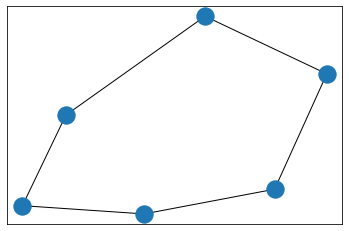

In [87]:
best_weights = [(best_route[i], (best_route[(i+1)%6])) for i in range(6)]
G_bestDW = nx.from_edgelist(best_weights)

nx.draw_networkx_nodes(G_bestDW, pos)
nx.draw_networkx_edges(G_bestDW, pos)